In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!nvidia-smi

Wed Mar 12 12:24:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 60%   84C    P2            229W /  230W |   14230MiB /  24564MiB |     82%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")


from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])
from IPython.display import clear_output

from src.text_utils import trim_text_to_token_limit
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from langdetect import detect

from src.train_test_split import stratified_train_test_split

import evaluate


tqdm.pandas()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Results

Now that we have selected the optimal value of $r$ on the validation set, we will see how it performs on the test set

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", cache_dir = '/Data')

In [6]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


In [7]:
base_data = pd.read_json("data/wikipedia_dataset.json")

In [8]:
train_df , temp_df = stratified_train_test_split(base_data, test_size=0.4)
val_df , test_df = stratified_train_test_split(temp_df, test_size=0.5)
train_idx = train_df.id.tolist()
val_idx = val_df.id.tolist()
test_idx = test_df.id.tolist()

## Loading data

In [9]:
base_path = "data/generated_dataset_test_100_qwen-0.5b-instruct-summary-pt-rank{lora_rank}.pkl"

In [11]:
all_df = []
raw_model_df = pd.read_pickle("data/generated_dataset_Qwen2.5-0.5B-Instruct.pkl")
raw_model_df['model_name'] = "Qwen-0.5B-Instruct"

all_df.append(raw_model_df)

raw_model_df = pd.read_pickle("data/generated_dataset_test_100_Llama-3.2-1B-Instruct-bnb-4bit.pkl")
raw_model_df['model_name'] = "Llama-1B-Instruct"

all_df.append(raw_model_df)

raw_model_df = pd.read_pickle("data/generated_dataset_test_100_Qwen2.5-3B-Instruct-unsloth-bnb-4bit.pkl")
raw_model_df['model_name'] = "Qwen-3B-Instruct"

all_df.append(raw_model_df)


for lora_rank in [64]:
    temp = pd.read_pickle(base_path.format(lora_rank = lora_rank))
    
    temp['model_name'] = "Finetuned Model"
    all_df.append(temp)


In [12]:
reference_summary = pd.read_pickle("data/generated_dataset_100_Meta-Llama-3.1-8B-Instruct-bnb-4bit_2.pkl")\
    .rename(columns = {'generated_text': 'reference_summary'})

# all_df.append(reference_summary)

In [13]:
generated_summaries = pd.concat(all_df, ignore_index=True)
generated_summaries

,id,generated_text,model_name
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,Qwen-0.5B-Instruct
1,10306,O elétron é uma partícula subatômica com símbo...,Qwen-0.5B-Instruct
2,2118886,"A rainha Sofia, filha do rei Constantino I, fo...",Qwen-0.5B-Instruct
3,1695,Aqui está um resumo do texto em português:\n\n...,Qwen-0.5B-Instruct
4,5448408,A crise migratória venezuelana é uma emigração...,Qwen-0.5B-Instruct
...,...,...,...
10995,5968453,O texto não fornece um resumo de no máximo 100...,Finetuned Model
10996,10830,"O texto apresenta eventos históricos, incluind...",Finetuned Model
10997,10667,"O texto apresenta eventos históricos, incluind...",Finetuned Model
10998,10894,"O texto apresenta eventos históricos, incluind...",Finetuned Model


In [14]:
test_mask = generated_summaries\
    .id\
    .isin(test_idx)
test_summaries = generated_summaries[test_mask]

In [15]:
df = pd.merge(
    test_summaries,
    reference_summary,
    on='id',
    how = 'left'
)
df

,id,generated_text,model_name,reference_summary
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,Qwen-0.5B-Instruct,O Los Angeles Lakers é um time de basquetebol ...
1,10306,O elétron é uma partícula subatômica com símbo...,Qwen-0.5B-Instruct,O elétron é uma partícula subatômica com carga...
2,115343,Aqui está um resumo do texto:\n\nO Athlon é um...,Qwen-0.5B-Instruct,O Athlon é uma série de processadores da plata...
3,939,A Guiné-Bissau é uma região do continente afri...,Qwen-0.5B-Instruct,A Guiné-Bissau é um país da África Ocidental c...
4,8695,O africâner é uma língua germânica do ramo ind...,Qwen-0.5B-Instruct,"O africâner, também conhecido como afrikaans, ..."
...,...,...,...,...
3995,2197537,Luis Alberto Suárez é um futebolista uruguaio ...,Finetuned Model,O texto lista quatro pessoas com o nome Luis S...
3996,97695,"Fontvieille é um bairro do Mónaco, localizado ...",Finetuned Model,Fontvieille é um bairro do Mónaco localizado e...
3997,87314,Sabbia é uma comuna italiana da região do Piem...,Finetuned Model,Sabbia é uma comuna italiana localizada na reg...
3998,10830,"O texto apresenta eventos históricos, incluind...",Finetuned Model,"Infelizmente, não há texto disponível para ger..."


## Qualitative analysis

In [16]:
print(df.query('model_name == "Finetuned Model"').iloc[0]['generated_text'])

O Los Angeles Lakers é um time de basquetebol da NBA que foi fundado em 1947 em Minneapolis, Minnesota. A equipe venceu cinco títulos da liga antes de uma queda de público. O Lakers conta com 56 aparições na pós-temporada, 33 títulos da Divisão do Pacífico e 32 títulos da Conferência Oeste. O time é detentora de alguns recordes da Liga e é considerado uma das franquias mais populares da NBA.<|eot_id|><|im_end|>


## Sequence length

We verify if the summary has ~ 100 words

In [17]:
df['reference_length'] = df['reference_summary']\
    .progress_apply(lambda x: len(x.split()))
df['generated_length'] = df['generated_text']\
    .progress_apply(lambda x: len(x.split()))

100%|██████████| 4000/4000 [00:00<00:00, 195563.72it/s]


<Axes: xlabel='reference_length', ylabel='Count'>

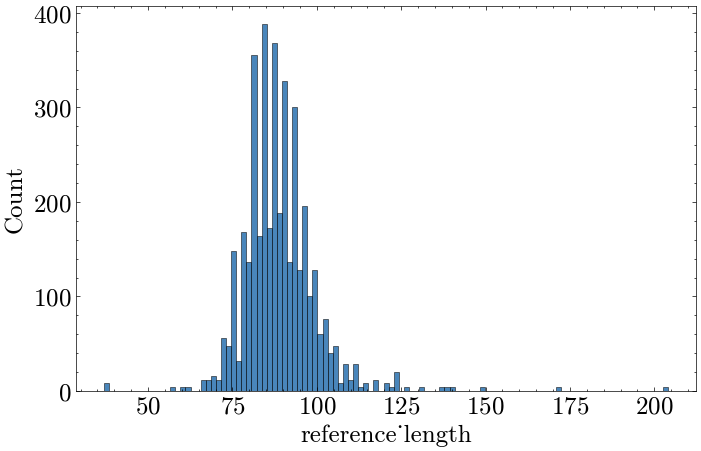

In [18]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'reference_length',
)

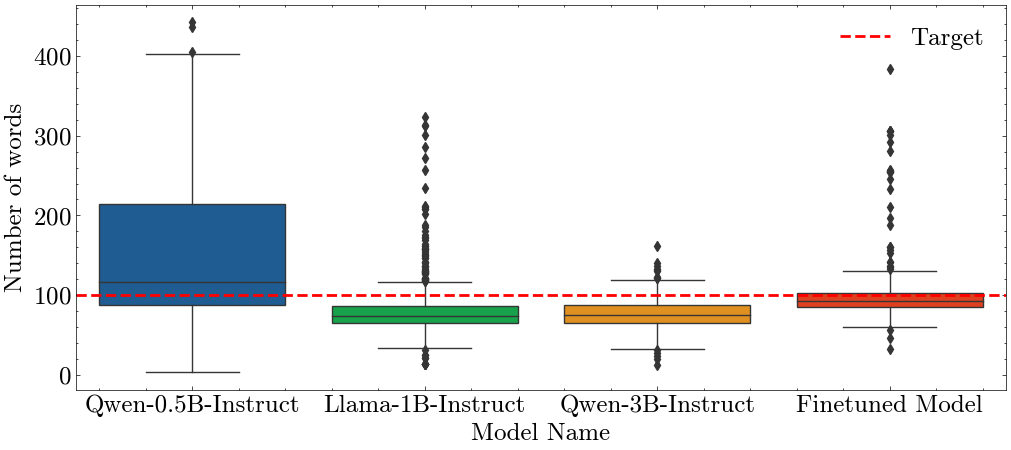

In [19]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (12,5))
sns.boxplot(
    df,
    y = 'generated_length',
    x='model_name',
    # palette= 'viridis_r',
    # alpha = 0.6
)

plt.hlines(100, xmin=-0.5, xmax = 3.5, colors='red', linestyles='dashed', linewidth = 2, label = 'Target')

plt.ylabel("Number of words")
plt.xlabel("Model Name")
plt.legend()

Text(0.5, 0, 'Number of words')

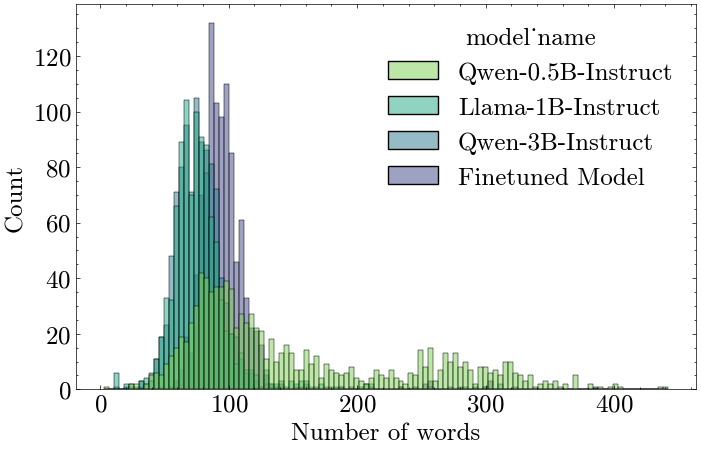

In [20]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'generated_length',
    hue='model_name',
    palette= 'viridis_r',
    # alpha = 0.6
)

plt.xlabel("Number of words")

In [21]:
df.groupby("model_name")\
    .generated_length\
    .describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
Finetuned Model,1000.0,97.092,27.217758,32.0,85.00,93.0,103.0,384.0
Llama-1B-Instruct,1000.0,79.323,30.152377,14.0,65.00,74.0,86.0,324.0
Qwen-0.5B-Instruct,1000.0,152.500,87.459460,3.0,87.00,117.0,214.0,442.0
Qwen-3B-Instruct,1000.0,75.969,16.774487,12.0,64.75,75.0,87.0,162.0


## Language

Checking how many texts are not in portuguese

In [23]:
def detect_language(x):
    try:
        return detect(x)
    
    except:
        return None
df['language'] = df['generated_text'].progress_apply(detect_language)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:09<00:00, 426.44it/s]


In [24]:
def count_non_portuguese_text(df):
    return (df['language'] != 'pt').sum()/len(df)

df.groupby("model_name")\
    .progress_apply(count_non_portuguese_text)

100%|██████████| 4/4 [00:00<00:00, 2107.43it/s]


model_name
Finetuned Model       0.004
Llama-1B-Instruct     0.002
Qwen-0.5B-Instruct    0.019
Qwen-3B-Instruct      0.000
dtype: float64

In [25]:
predictions = df["generated_text"].tolist()
references = df["reference_summary"].tolist()

In [26]:
checkpoint_groups = df.groupby("model_name")
rouge = evaluate.load("rouge")
# Store results
checkpoint_rouge_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing ROUGE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = rouge.compute(predictions=predictions, references=references)
    
    # Store the results
    checkpoint_rouge_scores[checkpoint] = scores

Computing ROUGE per checkpoint: 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


In [27]:
pd.DataFrame(checkpoint_rouge_scores).T

,rouge1,rouge2,rougeL,rougeLsum
Finetuned Model,0.544618,0.324723,0.409241,0.410528
Llama-1B-Instruct,0.501850,0.274578,0.367534,0.371002
Qwen-0.5B-Instruct,0.404482,0.212115,0.293828,0.296098
Qwen-3B-Instruct,0.499342,0.254859,0.351673,0.352539


In [28]:
checkpoint_groups = df.groupby("model_name")
bertscore = evaluate.load("bertscore")

# Store results
checkpoint_bert_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing BERT-SCORE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = bertscore.compute(predictions=predictions, references=references, lang = 'pt',)
    
    # Store the results
    checkpoint_bert_scores[checkpoint] = scores

Computing BERT-SCORE per checkpoint: 100%|██████████| 4/4 [01:03<00:00, 15.87s/it]


In [40]:
{k:np.mean(v['f1']) for k, v in checkpoint_bert_scores.items()}

{'Finetuned Model': 0.7949225008189679,
 'Llama-1B-Instruct': 0.7794663484096527,
 'Qwen-0.5B-Instruct': 0.7410071203708649,
 'Qwen-3B-Instruct': 0.7859819431900978}

In [29]:
temp = pd.DataFrame(checkpoint_bert_scores)\
    .loc['f1']\
    .to_dict()


<Axes: xlabel='BertScore', ylabel='Proportion'>

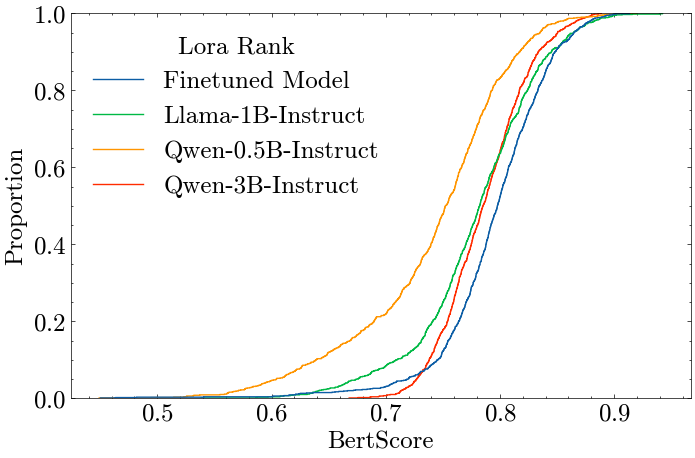

In [30]:
data = pd.DataFrame(temp).melt(var_name='Lora Rank', value_name='BertScore')

plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.ecdfplot(
    data,
    hue = 'Lora Rank',
    x = 'BertScore',
    # palette='crest'
)

In [46]:
df

,id,generated_text,model_name,reference_summary,reference_length,generated_length,language
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,Qwen-0.5B-Instruct,O Los Angeles Lakers é um time de basquetebol ...,95,333,pt
1,10306,O elétron é uma partícula subatômica com símbo...,Qwen-0.5B-Instruct,O elétron é uma partícula subatômica com carga...,74,250,pt
2,115343,Aqui está um resumo do texto:\n\nO Athlon é um...,Qwen-0.5B-Instruct,O Athlon é uma série de processadores da plata...,101,122,pt
3,939,A Guiné-Bissau é uma região do continente afri...,Qwen-0.5B-Instruct,A Guiné-Bissau é um país da África Ocidental c...,94,170,pt
4,8695,O africâner é uma língua germânica do ramo ind...,Qwen-0.5B-Instruct,"O africâner, também conhecido como afrikaans, ...",92,77,pt
...,...,...,...,...,...,...,...
3995,2197537,Luis Alberto Suárez é um futebolista uruguaio ...,Finetuned Model,O texto lista quatro pessoas com o nome Luis S...,58,69,pt
3996,97695,"Fontvieille é um bairro do Mónaco, localizado ...",Finetuned Model,Fontvieille é um bairro do Mónaco localizado e...,72,56,pt
3997,87314,Sabbia é uma comuna italiana da região do Piem...,Finetuned Model,Sabbia é uma comuna italiana localizada na reg...,61,88,pt
3998,10830,"O texto apresenta eventos históricos, incluind...",Finetuned Model,"Infelizmente, não há texto disponível para ger...",37,71,pt


## Stratified results

Check how the context length of the original text affect the output

In [31]:
df_all = pd.merge(
    df,
    base_data[['id','num_tokens']],
    on = 'id',
    how = 'left'
)

In [32]:
df_all['num_tokens_bin'] = pd.cut(df_all['num_tokens'],  np.linspace(0, 4000, 9))

In [33]:
df_all.groupby(["num_tokens_bin", "model_name"]).mean()

/tmp/ipykernel_1477822/1115848357.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(["num_tokens_bin", "model_name"]).mean()


id  reference_length  \
num_tokens_bin   model_name                                           
(0.0, 500.0]     Finetuned Model     1.591538e+06         82.209302   
                 Llama-1B-Instruct   1.591538e+06         82.209302   
                 Qwen-0.5B-Instruct  1.591538e+06         82.209302   
                 Qwen-3B-Instruct    1.591538e+06         82.209302   
(500.0, 1000.0]  Finetuned Model     1.599240e+06         86.986547   
                 Llama-1B-Instruct   1.599240e+06         86.986547   
                 Qwen-0.5B-Instruct  1.599240e+06         86.986547   
                 Qwen-3B-Instruct    1.599240e+06         86.986547   
(1000.0, 1500.0] Finetuned Model     1.428368e+06         88.815385   
                 Llama-1B-Instruct   1.428368e+06         88.815385   
                 Qwen-0.5B-Instruct  1.428368e+06         88.815385   
                 Qwen-3B-Instruct    1.428368e+06         88.815385   
(1500.0, 2000.0] Finetuned Model     9.947756e+05         88.664557   
                 Llama-1B-Instruct   9.947756e+05         88.664557   
                 Qwen-0.5B-Instruct  9.947756e+05         88.664557   
                 Qwen-3B-Instruct    9.947756e+05         88.664557   
(2000.0, 2500.0] Finetuned Model     1.342016e+06         89.853448   
                 Llama-1B-Instruct   1.342016e+06         89.853448   
                 Qwen-0.5B-Instruct  1.342016e+06         89.853448   
                 Qwen-3B-Instruct    1.342016e+06         89.853448   
(2500.0, 3000.0] Finetuned Model     8.626769e+05         91.549451   
                 Llama-1B-Instruct   8.626769e+05         91.549451   
                 Qwen-0.5B-Instruct  8.626769e+05         91.549451   
                 Qwen-3B-Instruct    8.626769e+05         91.549451   
(3000.0, 3500.0] Finetuned Model     8.085520e+05         93.804598   
                 Llama-1B-Instruct   8.085520e+05         93.804598   
                 Qwen-0.5B-Instruct  8.085520e+05         93.804598   
                 Qwen-3B-Instruct    8.085520e+05         93.804598   
(3500.0, 4000.0] Finetuned Model     8.206502e+05         96.318182   
                 Llama-1B-Instruct   8.206502e+05         96.318182   
                 Qwen-0.5B-Instruct  8.206502e+05         96.318182   
                 Qwen-3B-Instruct    8.206502e+05         96.318182   

                                     generated_length   num_tokens  
num_tokens_bin   model_name                                         
(0.0, 500.0]     Finetuned Model            89.627907   353.104651  
                 Llama-1B-Instruct          72.813953   353.104651  
                 Qwen-0.5B-Instruct        128.616279   353.104651  
                 Qwen-3B-Instruct           55.348837   353.104651  
(500.0, 1000.0]  Finetuned Model            95.094170   751.336323  
                 Llama-1B-Instruct          78.439462   751.336323  
                 Qwen-0.5B-Instruct        128.919283   751.336323  
                 Qwen-3B-Instruct           68.331839   751.336323  
(1000.0, 1500.0] Finetuned Model            98.143590  1246.420513  
                 Llama-1B-Instruct          80.010256  1246.420513  
                 Qwen-0.5B-Instruct        149.194872  1246.420513  
                 Qwen-3B-Instruct           78.441026  1246.420513  
(1500.0, 2000.0] Finetuned Model            99.594937  1753.550633  
                 Llama-1B-Instruct          77.392405  1753.550633  
                 Qwen-0.5B-Instruct        166.816456  1753.550633  
                 Qwen-3B-Instruct           81.392405  1753.550633  
(2000.0, 2500.0] Finetuned Model            99.793103  2242.008621  
                 Llama-1B-Instruct          79.422414  2242.008621  
                 Qwen-0.5B-Instruct        155.706897  2242.008621  
                 Qwen-3B-Instruct           83.551724  2242.008621  
(2500.0, 3000.0] Finetuned Model            97.912088  2728.549451  
                 Llama-1B-Instruct          7

/tmp/ipykernel_1477822/3942624449.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


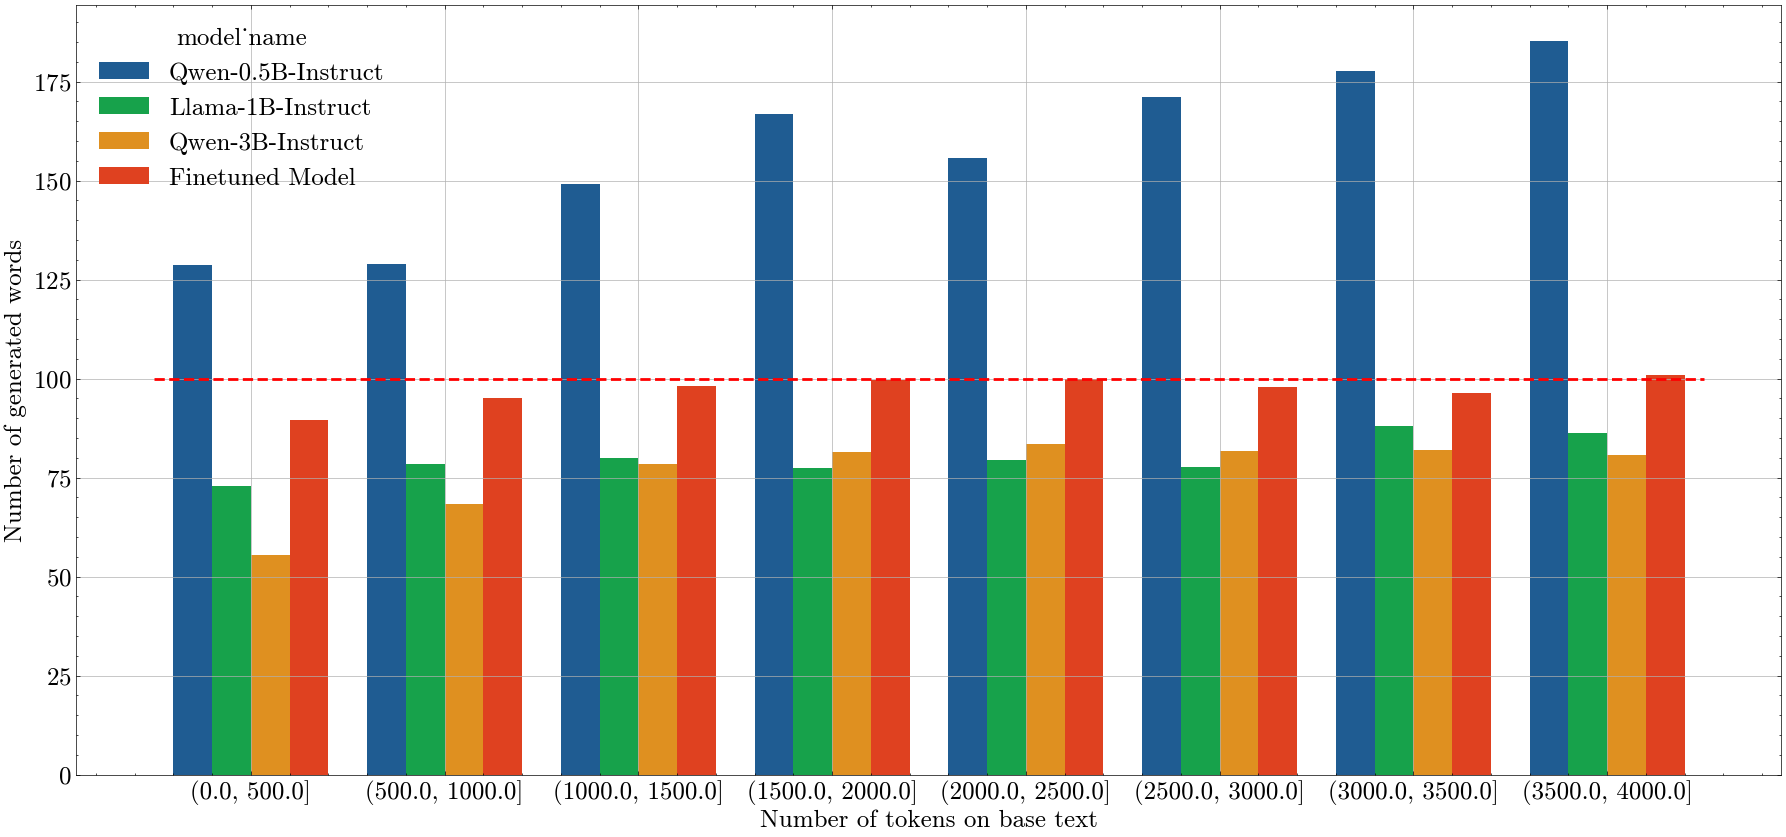

In [34]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (22,10))
sns.barplot(
    df_all,
    x = 'num_tokens_bin',
    y = 'generated_length',
    hue = 'model_name',
    ci = None
)

plt.hlines(100, -0.5, 7.5, colors= 'red', linestyles='dashed', linewidth = 2)
plt.xlabel("Number of tokens on base text")
plt.ylabel("Number of generated words")
plt.grid()

In [89]:
checkpoint_groups = df_all.groupby("model_name")
bertscore = evaluate.load("bertscore")

# Store results
checkpoint_bert_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing BERT-SCORE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = bertscore.compute(predictions=predictions, references=references, lang = 'pt',)
    
    # Store the results
    checkpoint_bert_scores[checkpoint] = scores

Computing BERT-SCORE per checkpoint: 100%|██████████| 3/3 [00:55<00:00, 18.37s/it]


In [91]:
temp = pd.DataFrame(checkpoint_bert_scores)\
    .loc['f1']\
    .to_dict()

data = pd.DataFrame(temp).melt(var_name='Model Name', value_name='BertScore')

In [92]:
data

,Model Name,BertScore
0,Finetuned Model,0.776098
1,Finetuned Model,0.881138
2,Finetuned Model,0.755672
3,Finetuned Model,0.830631
4,Finetuned Model,0.816896
...,...,...
2995,Qwen-0.5B-Instruct,0.789775
2996,Qwen-0.5B-Instruct,0.919405
2997,Qwen-0.5B-Instruct,0.890204
2998,Qwen-0.5B-Instruct,0.651694
